<img src="images/keepcoding.png" width=200 align="left">

# Módulo de Matemáticas 101: práctica

Vamos a poner de nuevo en práctica lo que hemos visto en este módulo. La práctica se centra en la regresión lineal (¡tema muy importante!) y podéis preguntarme las dudas que tengáis por Discord. ¡Mucha suerte!

<img src="./images/luck.gif" alt="Drawing" style="width: 300px;"/>

## 1. Regresión lineal con mínimos cuadrados

En este ejercicio vamos a implementar la forma matricial de la regresión lineal con el método de los mínimos cuadrados. Para ello, tendrás que:

- Explorar un dataset
- Implementar la regresión lineal
- Aplicarla a un dataset concreto

Como recordatorio, los valores de los pesos $\widehat{w}$ vienen dados por:

<center>$\widehat{w} = (X^T X)^{-1}X^T y,$</center>

Donde $y$ es la variable a predecir y $X$ la matriz de features (NOTA: revisa cómo se define en los apuntes). Sabemos que los pesos van a ser los parámetros de la ecuación lineal que estamos intentando ajustar y tendremos uno por cada variable de entrada que usemos y además un término independiente o bias.

### 1.1 Carga del dataset y exploración de datos

Vamos a usar el dataset de [Auto MPG](https://archive.ics.uci.edu/dataset/9/auto+mpg) que podemos encontrar en el [repositorio de Machine learning de UC Irvine](https://archive.ics.uci.edu/). Lo primero, vamos a familiarizarnos con los datos.

En el propio repositorio nos indican cómo descargar el dataset con su librería (podemos consultar el código fuente si queremos).

In [1]:
!pip install ucimlrepo

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
auto_mpg = fetch_ucirepo(id=9) 
  
# data (as pandas dataframes) 
X = auto_mpg.data.features 
y = auto_mpg.data.targets 
  
# metadata 
print(auto_mpg.metadata) 
  
# variable information 
print(auto_mpg.variables) 


{'uci_id': 9, 'name': 'Auto MPG', 'repository_url': 'https://archive.ics.uci.edu/dataset/9/auto+mpg', 'data_url': 'https://archive.ics.uci.edu/static/public/9/data.csv', 'abstract': 'Revised from CMU StatLib library, data concerns city-cycle fuel consumption', 'area': 'Other', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 398, 'num_features': 7, 'feature_types': ['Real', 'Categorical', 'Integer'], 'demographics': [], 'target_col': ['mpg'], 'index_col': ['car_name'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1993, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5859H', 'creators': ['R. Quinlan'], 'intro_paper': None, 'additional_info': {'summary': 'This dataset is a slightly modified version of the dataset provided in the StatLib library.  In line with the use by Ross Quinlan (1993) in predicting the attribute "mpg", 8 of the original instances were removed because they had unknown values for th

Con la función `head` de Pandas podemos ver las primeras filas del dataset.

In [3]:
X.head()

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin
0,307.0,8,130.0,3504,12.0,70,1
1,350.0,8,165.0,3693,11.5,70,1
2,318.0,8,150.0,3436,11.0,70,1
3,304.0,8,150.0,3433,12.0,70,1
4,302.0,8,140.0,3449,10.5,70,1


In [4]:
y.head()

,mpg
0,18.0
1,15.0
2,18.0
3,16.0
4,17.0


En este punto, puedes hacer cualquier otro análisis exploratorio que creas conveniente.

In [5]:
print(X.shape)
print(y.shape)

(398, 7)
(398, 1)


A continuación, crea una función a la que le pases los dataframes de features y de target y el nombre de la variable y haga la gráfica del target (consumo en millas por galón) vs la variable que le ha llegado por parámetro. Puedes ver un ejemplo de gráfica más abajo, pero usa los parámetros que quieras en cuanto a color de los puntos, grids etc.

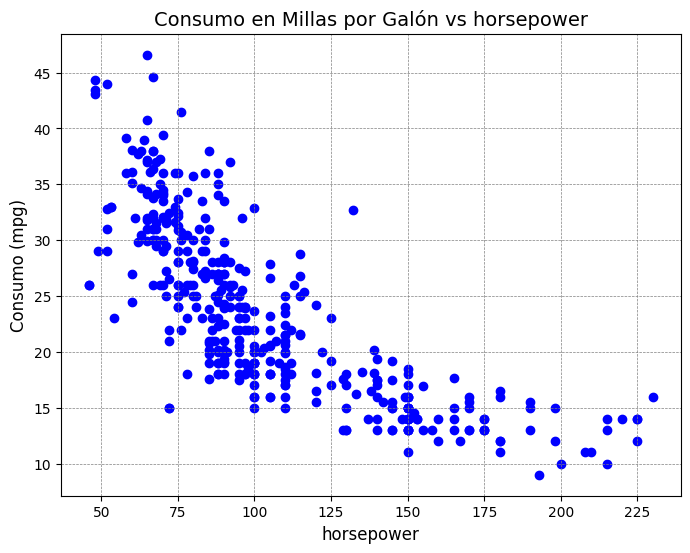

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def visualiza(df, y, nombre_columna):
    """ 
    Genera un gráfico del consumo en millas por galón vs una variable específica. 
    Parámetros: 
    df: DataFrame con las características. 
    y: DataFrame con la variable objetivo. 
    nombre_columna (str): El nombre de la variable a representar en la gráfica. 
    """
    #Verificar si la variable nombre_columna existe en las características:
    if nombre_columna not in df.columns:
        raise ValueError(f"La variable '{nombre_columna}' no se encuentra en las variables del Data Frame.")
    
    # Unir el DataFrame de características y el DataFrame objetivo en un solo DataFrame:
    df_concat = pd.concat([df, y], axis=1)
    
    #Crear la gráfica
    plt.figure(figsize=(8, 6))
    plt.scatter(df_concat[nombre_columna], df_concat[y.columns[0]], color="blue")
    plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
    plt.title(f"Consumo en Millas por Galón vs {nombre_columna}", fontsize=14)
    plt.xlabel(nombre_columna, fontsize=12)
    plt.ylabel("Consumo (mpg)", fontsize=12)
    plt.show()

visualiza(X, y, 'horsepower')


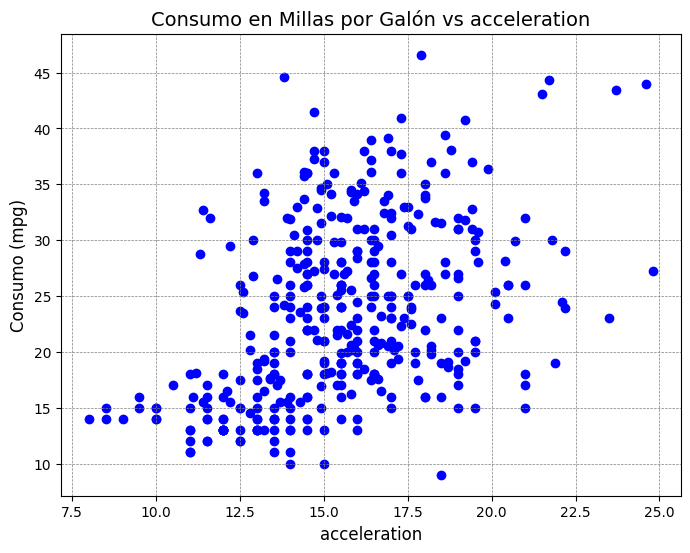

In [7]:
visualiza(X, y, 'acceleration')

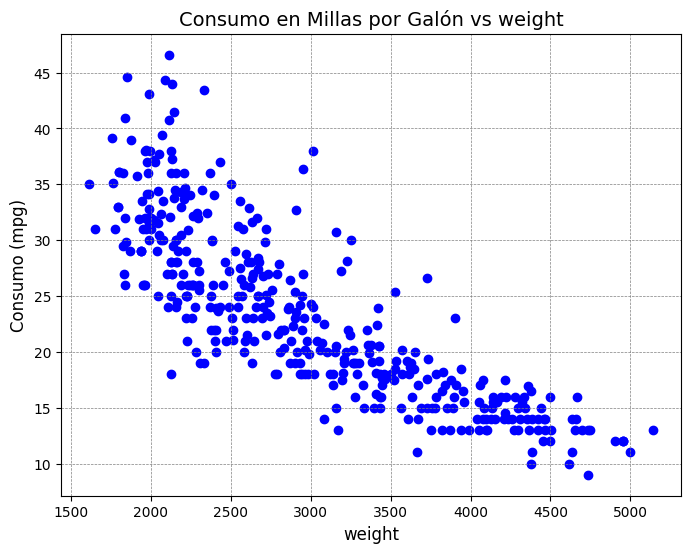

In [8]:
visualiza(X, y, 'weight')

IMPORTANTE: Aunque lo ideal sería un modelo multivariante, vamos a elegir la variable `weight` y hacer una regresión lineal solo con esta variable.

### 1.2 Implementación del modelo

En este punto vamos a dar un paso atrás y olvidarnos de los datos de consumo por un momento, porque el algoritmo que vamos a implementar serviría para cualquier conjunto de datos.

Lo primero, implementa una función que devuelva los valores de $\widehat{w}$ dados X e y. Si se da el caso de que el dataset tiene más features que observaciones, queremos transponerlo antes de realizar las operaciones. Lo hacemos porque, como vimos en clase, los resultados no van a ser buenos si el número de observaciones es menor.

In [9]:
import numpy as np

def pesos_ols(X, y):
    """
    Devuelve los valores del vector de pesos o de coeficientes (w), a partir de 
    X e y.
    Parámetros: 
    X: Matriz de características
    y: Vector objetivo. 
    Si X tiene más características que observaciones, se transpone antes de 
    realizar las operaciones.
    
    """
    #Comprobar que las dimensiones son adecuadas y corrigir si no es así
    if X.shape[1] > X.shape[0]:
        X = X.T
        
    #Preparar la matriz X para que tenga la forma adecuada para aplicar la fórmula 
    ones = np.ones((X.shape[0], 1))
    X_c = np.concatenate((ones, X), axis = 1)
    X_c_t = X_c.T
    inv = np.linalg.inv(np.dot(X_c_t, X_c)) 

    #Calcular el vector de pesos
    w = inv @ X_c_t @ y

    return w

### 1.3 Prueba del modelo en los datos de consumo de coches

Ya podemos usar nuestra función `pesos` en el dataset real que hemos descargado, el de consumo de combustible. Para ver el ajuste, dibuja de nuevo los datos junto con la recta que has obtenido, en la misma gráfica. Tendrás que convertir los dataframes de Pandas en arrays de numpy para poder aplicar las operaciones matriciales.

TIP: Revisa las dimensiones de todos los arrays para ver que son correctas.

In [10]:
# Array de prueba!!
X_prueba = np.array([[1710, 1262, 1786, 1717, 2198, 1362, 1694, 2090, 1774, 1077], 
              [2003, 1976, 2001, 1915, 2000, 1993, 2004, 1973, 1931, 1939]])
y_prueba = np.array([208500, 181500, 223500, 140000, 250000, 143000, 307000, 200000, 129900, 118000])
pesos_ols(X_prueba, y_prueba)

array([-2.29223802e+06,  5.92536529e+01,  1.20780450e+03])

Hemos implementado el algoritmo de mínimos cuadrados y lo hemos probado en un array de tamaño 2x10. Como pista, el resultado que he obtenido para este array de prueba es el siguiente:

array([-2.29223802e+06,  5.92536529e+01,  1.20780450e+03])

<span style="font-size: 24px;"> 1.3 Prueba del modelo en los datos de consumo de coches

Ya podemos usar nuestra función pesos en el dataset real que hemos descargado, el de consumo de combustible. Para ver el ajuste, dibuja de nuevo los datos junto con la recta que has obtenido, en la misma gráfica. Tendrás que convertir los dataframes de Pandas en arrays de numpy para poder aplicar las operaciones matriciales.

TIP: Revisa las dimensiones de todos los arrays para ver que son correctas

(398, 1)
(398, 1)
[[ 4.63173644e+01]
 [-7.67661006e-03]]


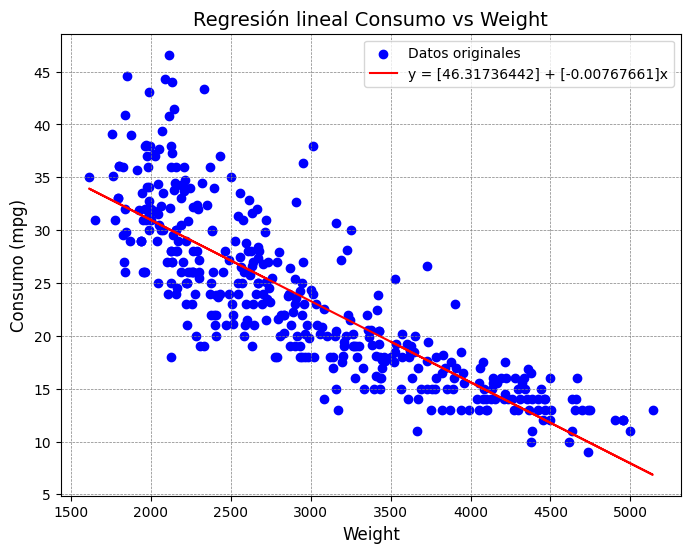

In [11]:
import pandas as pd

#Transformar los dataframe de Pandas en arrays de numpy:
X_array = np.array(X)
y_array = np.array(y)
#Seleccionar la columna "weight" y convertir el vector resultante en una matriz (2D):
X_weight = X_array[:,3]
X_matrix = X_weight.reshape(-1, 1)

print(X_matrix.shape)
print(y_array.shape)

#Aplicar el modelo y dibujar la recta junto con los datos originales:
w = pesos_ols(X_matrix, y_array)
print(w)

plt.figure(figsize=(8, 6)) 
plt.scatter(X_matrix, y_array, color="blue", label="Datos originales") 
plt.plot(X_matrix, w[0] + w[1] * X_matrix, color="red", label=f"y = {w[0]} + {w[1]}x") 
plt.grid(True, color='gray', linestyle='--', linewidth=0.5) 
plt.title("Regresión lineal Consumo vs Weight", fontsize=14) 
plt.xlabel("Weight", fontsize=12)
plt.ylabel("Consumo (mpg)", fontsize=12) 
plt.legend() 
plt.show()


Por último, vamos a comprobar el resultado con el que nos da `scikit-learn`para ver si nuestra implementación tiene buena pinta. Podemos ver cómo funciona en la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [12]:
!pip install scikit-learn
from sklearn.linear_model import LinearRegression

# Creamos el objeto
lr = LinearRegression()

# Le pasamos los datos en el formato correcto
X = auto_mpg.data.features 
y = auto_mpg.data.targets 

X_lr = X[['weight']]
y_lr = y

# Entrenamos con los datos
lr.fit(X_lr,y_lr)
print("Punto de corte:", lr.intercept_)
print("Pendiente:", lr.coef_)

Defaulting to user installation because normal site-packages is not writeable
Punto de corte: [46.31736442]
Pendiente: [[-0.00767661]]


**TODO**: Analiza el resultado obtenido y compáralo con el de sklearn

El resultado de la regresión lineal por mínimos cuadrados con sklearn es igual al obtenido con la función pesos_ols(X, y) operando con las matrices, ya que presentan los mismos coeficientes (w0 = 46.31736442, w1 = -0.00767661).

### 1.4 Compara el método de mínimos cuadrados y el descenso del gradiente para obtener los coeficientes de una regresión lineal



1 Método de Mínimos cuadrados:
- Calcula los coeficientes óptimos (w) de manera que se minimiza la suma de los errores cuadrados entre los valores observados y los valores predichos.
- Se obtiene una solución exacta mediante un cálculo de álgebra lineal.
- Es un método más rápido, útil cuando el conjunto de datos es pequeño o mediano.
- Puede ser un método costoso computacionalmente y consumir mucha memoria para grandes volúmenes de datos y cuando existe colinealidad entre variables, debido al cálculo de la inversa, ya que no sería posible.
- Fórmula: $$\mathbf{w} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$$



2 Método Descenso de gradiente: 
- Es un método de optimización en el que los coeficientes (w) se determinan de manera iterativa, minimizando la función de pérdida mediante ajustes graduales en la dirección opuesta al gradiente de la pérdida.
- Es un método que requiere de una **función objetivo** (RSS), una tasa de aprendizaje o "learning rate" y un número de iteraciones.
- Es una solución aproximada, no exacta.
- Es un método más adecuado para grandes volúmenes de datos, cuando hay colinealidad entre variables, en general para optimizar modelos más complejos típicos de IA, ya que no requiere calcular la inversa de matrices.
- Es importante ajustar correctamente la tasa de aprendizaje y el número de iteraciones, ya que puede afectar al rendimiento y a la convergencia.
- Fórmula: $$\mathbf{w}^{t+1} = \mathbf{w}^t - \eta \nabla RSS(\mathbf{w})$$



## 2. Optimización con descenso del gradiente [OPCIONAL]

Este ejercicio es opcional, no es necesario hacerlo para conseguir el APTO en la práctica, pero podéis hacerlo si queréis practicar más sobre el método del descenso del gradiente, que es muy importante en machine learning.

Vamos a resolver el mismo problema usando el descenso del gradiente en lugar de la solución analítica. El descenso del gradiente es un método de optimización iterativo que usa el operador gradiente.

Como es iterativo, necesitamos decirle cuándo tiene que parar y darnos la solución. En este caso, le vamos a decir que pare y nos devuelva la solución después de un número de iteraciones que le pasaremos como parámetro. La ecuación iterativa es.

$$w^{t+1} = w^t - \eta \cdot \nabla f(w)$$

donde f es nuestra función objetivo, y w es un vector. Para la función objetivo, vamos a usar el error RSS, que querremos minimizar.

$$ RSS(w) = \frac{1}{2}\sum_{n=1}^{N}[y_n-f(x_n)]^2$$

y cuyo gradiente es:

$$\nabla RSS(w) = X^T(Xw^t-y)$$

TIP: Ten en cuenta que el RSS también lo puedes escribir como $\frac{1}{2}\sum_{n=1}^{N}[y_n-\hat{y_n}]^2$ donde $\hat{y_n} = X \hat{w}$ en cada paso.

### 2.1 Implementar el descenso del gradiente

Completa las siguientes funciones para implementar el descenso del gradiente con la función objetivo de la regresión lineal. La función necesitará:

- La entrada X y salida y de la regresión
- Un punto inicial desde el que empezar a iterar
- El número de iteraciones 
- El learning rate

La función nos devolverá un array con las w resultantes de las iteraciones y otro con el valor de la función en cada paso del algoritmo, a la que también se conoce como *loss function*.

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def gradient_descent(X, y, w0, n_iter, eta): 
    """
    Implementa el descenso del gradiente para la regresión lineal y devuelve un array 
    con los valores de w resultantes de las iteraciones y otro array con el valor de la 
    función en cada paso del algoritmo (loss function).
    Parámetros:
    X: Matriz de características.
    y: Vector valores objetivo asociados a las obaservaciones de X.
    w0: Vector inicial de pesos o coeficientes.
    n_iter: número de iteraciones.
    eta: Tasa de aprendizaje (learning rate).
    """
    # Inicializamos variables
    loss_iter = [np.inf]
    w_iter = w0
  
    # Añadir la columna de 1s
    X = np.concatenate((np.ones((len(y), 1)), X), axis = 1) 
    
    # Hacer un bucle para las iteraciones 
    for i in range(n_iter):
        y_hat = np.dot(X, w_iter)
        error = y_hat - y
        rss_iter = (1/2) * np.dot(error.T, error) # 1/2 (y_hat - y)ˆ2
        loss_iter.append(rss_iter.item())
        grad_rss = np.dot(X.T, error)
        w_iter =  w_iter - eta * grad_rss
    
    # Devuelve los resultados
    return np.array(w_iter), np.array(loss_iter)

eta = 0.01 
iteraciones = 2000 

np.random.seed(123)
w0 = np.random.rand(2).reshape((2,1))

y = np.array([208500, 181500, 223500, 140000, 250000]).reshape((5,1))
X = np.array( [[  0.37020659],
               [  -0.48234664],
               [  0.51483616],
               [  0.38352774],
               [  1.29888065]])

weights, loss = gradient_descent(X, y, w0, iteraciones, eta)
print(weights)

[[183845.82320222]
 [ 40415.66453324]]


### 2.2 Aplicar al dataset de consumo de combustible

Leemos de nuevo los datos y aplicamos la función que acabamos de programar.

In [32]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
auto_mpg = fetch_ucirepo(id=9) 
  
# data (as pandas dataframes) 
X = auto_mpg.data.features 
y = auto_mpg.data.targets 
  
# convert to numpy
X_np = X['weight'].to_numpy().reshape((X.shape[0], 1))
y_np = y.to_numpy()

print(X_np.shape)
print(y_np.shape)


(398, 1)
(398, 1)


Para ayudar al algoritmo, vamos a escalar la variable X, restando la media y dividiendo entre la desviación estándar. Después aplicamos la función anterior y dibujamos.

[[23.51457286]
 [-6.49270202]]


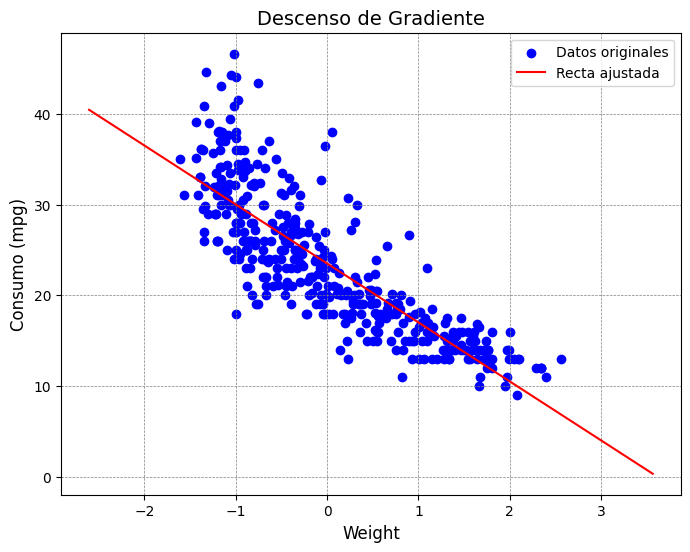

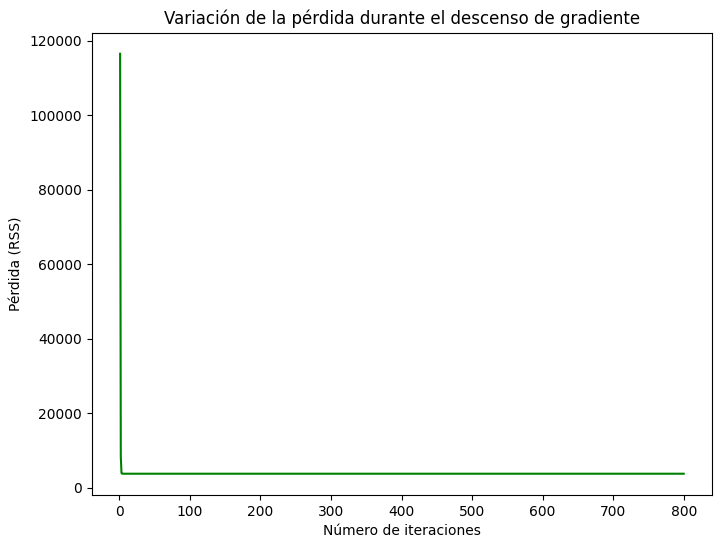

In [57]:
# Aplicar el modelo y dibujar la recta junto con los datos

X = auto_mpg.data.features
y = auto_mpg.data.targets

# Escalar la variable x 

X_np = X['weight'].to_numpy().reshape((X.shape[0], 1))
y_np = y.to_numpy()

X_gd=(X_np - X_np.mean()) / X_np.std()
y_gd = y_np

# Punto inicial, learning rate y número de iteraciones
eta = 0.002
np.random.seed(123)
w0 = np.random.rand(2).reshape((2,1))
n_iter = 800

# Aplicar el algoritmo
weights, loss = gradient_descent(X_gd, y_gd, w0, n_iter, eta)
print(weights)

# Límites de los ejes para las predicciones del modelo:
x_max = np.max(X_gd) + 1
x_min = np.min(X_gd) - 1

x_range = np.linspace(x_min, x_max, 100).reshape(-1, 1)
y_pred = weights[0] + weights[1] * x_range

#Gráfica de datos y recta ajustada
plt.figure(figsize=(8, 6)) 
plt.scatter(X_gd, y_gd, color="blue", label="Datos originales") 
plt.plot(x_range, y_pred, color="red", label="Recta ajustada") 
plt.grid(True, color='gray', linestyle='--', linewidth=0.5) 
plt.title("Descenso de Gradiente", fontsize=14) 
plt.xlabel("Weight", fontsize=12)
plt.ylabel("Consumo (mpg)", fontsize=12) 
plt.legend() 
plt.show()

#Gráfica de la variación de la pérdida
plt.figure(figsize=(8, 6))
plt.plot(range(len(loss)), loss, color='green')
plt.xlabel('Número de iteraciones')
plt.ylabel('Pérdida (RSS)')
plt.title('Variación de la pérdida durante el descenso de gradiente')
plt.show()
